In [1]:
%matplotlib inline

import os
import sys

PACKAGE_PARENT = '..'
sys.path.append(PACKAGE_PARENT)

import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from gaminet import GAMINetRegressor, GAMINetClassifier
from gaminet.utils import local_visualize
from gaminet.utils import global_visualize_density
from gaminet.utils import feature_importance_visualize
from gaminet.utils import plot_trajectory
from gaminet.utils import plot_regularization

## Load data

In [2]:
def metric_wrapper(metric, scaler):
    def wrapper(label, pred):
        return metric(label, pred, scaler=scaler)
    return wrapper

def rmse(label, pred, scaler):
    pred = scaler.inverse_transform(pred.reshape([-1, 1]))
    label = scaler.inverse_transform(label.reshape([-1, 1]))
    return np.sqrt(np.mean((pred - label)**2))

def data_generator1(datanum, dist="uniform", random_state=0):
    
    nfeatures = 10
    np.random.seed(random_state)
    x = np.random.uniform(0, 1, [datanum, nfeatures])
    x1, x2, x3, x4, x5, x6 = [x[:, [i]] for i in range(6)]

    def cliff(x1, x2):
        # x1: -20,20
        # x2: -10,5
        x1 = (2 * x1 - 1) * 20
        x2 = (2 * x2 - 1) * 7.5 - 2.5
        term1 = -0.5 * x1 ** 2 / 100
        term2 = -0.5 * (x2 + 0.03 * x1 ** 2 - 3) ** 2
        y = 10 * np.exp(term1 + term2)
        return  y

    y = (8 * (x1 - 0.5) ** 2
        + 0.1 * np.exp(-8 * x2 + 4)
        + 3 * np.sin(2 * np.pi * x3 * x4) + cliff(x5, x6)
        ).reshape([-1,1]) + 1 * np.random.normal(0, 1, [datanum, 1])

    task_type = "Regression"
    meta_info = {"X" + str(i + 1):{'type':'continuous'} for i in range(nfeatures)}
    meta_info.update({'Y':{'type':'target'}})         
    for i, (key, item) in enumerate(meta_info.items()):
        if item['type'] == 'target':
            sy = MinMaxScaler((0, 1))
            y = sy.fit_transform(y)
            meta_info[key]['scaler'] = sy
        else:
            sx = MinMaxScaler((0, 1))
            sx.fit([[0], [1]])
            x[:,[i]] = sx.transform(x[:,[i]])
            meta_info[key]['scaler'] = sx

    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=random_state)
    return train_x, test_x, train_y, test_y, task_type, meta_info, metric_wrapper(rmse, sy)

random_state = 0
train_x, test_x, train_y, test_y, task_type, meta_info, get_metric = data_generator1(datanum=100000, random_state=random_state)

In [3]:
from interpret.glassbox import ExplainableBoostingRegressor

clf = ExplainableBoostingRegressor(interactions=10, max_interaction_bins=64)
clf.fit(train_x, train_y)

pred_train = clf.predict(train_x)
pred_test = clf.predict(test_x)
ebm_stat = np.hstack([np.round(get_metric(train_y, pred_train),5),
                      np.round(get_metric(test_y, pred_test),5)])
print(ebm_stat)

[1.64631 1.6709 ]


## Train GAMI-Net 

In [4]:
model = GAMINetRegressor(interact_num=10,
                         subnet_size_main_effect=(20, ) ,
                         subnet_size_interaction=(20, 20),
                         max_epochs=(1000, 1000, 1000),
                         learning_rates=(0.001, 0.001, 0.0001),
                         early_stop_thres=("auto", "auto", "auto"),
                         batch_size=1000,
                         reg_clarity=1,
                         loss_threshold=0.01,
                         warm_start=True,
                         verbose=True,
                         random_state=random_state)
model.fit(train_x, train_y)

###############Run Warm Initialization for Main Effect###############


/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


####################Stage 1: Main Effect Training####################


Epoch:    1, train loss: 0.00865, validation loss: 0.00844: 100%|██████████| 64/64 [00:00<00:00, 138.47it/s]                       
Epoch:    2, train loss: 0.00859, validation loss: 0.00854: 100%|██████████| 64/64 [00:00<00:00, 207.34it/s]                       
Epoch:    3, train loss: 0.00859, validation loss: 0.00842: 100%|██████████| 64/64 [00:00<00:00, 242.95it/s]                       
Epoch:    4, train loss: 0.00857, validation loss: 0.00844: 100%|██████████| 64/64 [00:00<00:00, 234.16it/s]                       
Epoch:    5, train loss: 0.00858, validation loss: 0.00841: 100%|██████████| 64/64 [00:00<00:00, 242.17it/s]                       
Epoch:    6, train loss: 0.00859, validation loss: 0.00845: 100%|██████████| 64/64 [00:00<00:00, 248.10it/s]                       
Epoch:    7, train loss: 0.00857, validation loss: 0.00843: 100%|██████████| 64/64 [00:00<00:00, 232.41it/s]                       
Epoch:    8, train loss: 0.00855, validation loss: 0.00844: 100%|██████████|

Main Effect Training Stop at Epoch: 11, train loss: 0.00857, validation loss: 0.00846
###############Run Warm Initialization for Interaction###############
####################Stage 2: Interaction Training####################


Epoch:    1, train loss: 0.00232, validation loss: 0.00220: 100%|██████████| 64/64 [00:01<00:00, 61.24it/s]                        
Epoch:    2, train loss: 0.00214, validation loss: 0.00217: 100%|██████████| 64/64 [00:01<00:00, 61.36it/s]                        
Epoch:    3, train loss: 0.00208, validation loss: 0.00212: 100%|██████████| 64/64 [00:00<00:00, 67.47it/s]                        
Epoch:    4, train loss: 0.00203, validation loss: 0.00204: 100%|██████████| 64/64 [00:00<00:00, 75.32it/s]                        
Epoch:    5, train loss: 0.00198, validation loss: 0.00199: 100%|██████████| 64/64 [00:00<00:00, 75.64it/s]                        
Epoch:    6, train loss: 0.00195, validation loss: 0.00198: 100%|██████████| 64/64 [00:00<00:00, 73.73it/s]                        
Epoch:    7, train loss: 0.00193, validation loss: 0.00198: 100%|██████████| 64/64 [00:00<00:00, 73.64it/s]                        
Epoch:    8, train loss: 0.00190, validation loss: 0.00192: 100%|██████████|

Interaction Training Stop at Epoch: 41, train loss: 0.00169, validation loss: 0.00171
#########################Stage 3: Fine Tuning#########################


Epoch:    1, train loss: 0.00166, validation loss: 0.00167: 100%|██████████| 64/64 [00:00<00:00, 66.10it/s]                        
Epoch:    2, train loss: 0.00165, validation loss: 0.00167: 100%|██████████| 64/64 [00:00<00:00, 68.21it/s]                        
Epoch:    3, train loss: 0.00165, validation loss: 0.00167: 100%|██████████| 64/64 [00:00<00:00, 66.13it/s]                        
Epoch:    4, train loss: 0.00165, validation loss: 0.00167: 100%|██████████| 64/64 [00:00<00:00, 68.43it/s]                        
Epoch:    5, train loss: 0.00165, validation loss: 0.00167: 100%|██████████| 64/64 [00:00<00:00, 68.33it/s]                        
Epoch:    6, train loss: 0.00165, validation loss: 0.00167: 100%|██████████| 64/64 [00:00<00:00, 68.81it/s]                        
Epoch:    7, train loss: 0.00165, validation loss: 0.00166: 100%|██████████| 64/64 [00:00<00:00, 69.85it/s]                        
Epoch:    8, train loss: 0.00165, validation loss: 0.00166: 100%|██████████|

Fine Tuning Stop at Epoch: 17, train loss: 0.00164, validation loss: 0.00166


GAMINetRegressor(batch_size=1000, loss_threshold=0.01, reg_clarity=1,
                 verbose=True)

In [5]:
model.time_cost_

[('fit_interaction', 37.19),
 ('fine_tune_all', 15.95),
 ('warm_start_interaction', 4.72),
 ('warm_start_main_effect', 3.38),
 ('fit_main_effect', 3.22),
 ('add_interaction', 0.44),
 ('prune_interaction', 0.41),
 ('get_interaction_list', 0.31),
 ('prune_main_effect', 0.2)]

In [6]:
pred_train = model.predict(train_x)
pred_test = model.predict(test_x)
gaminet_stat = np.hstack([np.round(get_metric(train_y, pred_train),5),
                          np.round(get_metric(test_y, pred_test),5)])
print(gaminet_stat)

[1.0329  1.04452]


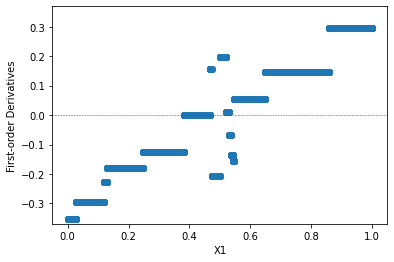

In [7]:
model.partial_derivatives(0)

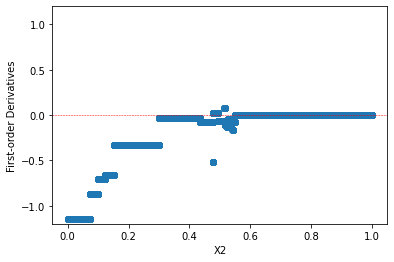

In [8]:
model.partial_derivatives(1)

In [9]:
model.get_clarity_loss(test_x)

3.313058005005587e-05

## Visualization

### Training details

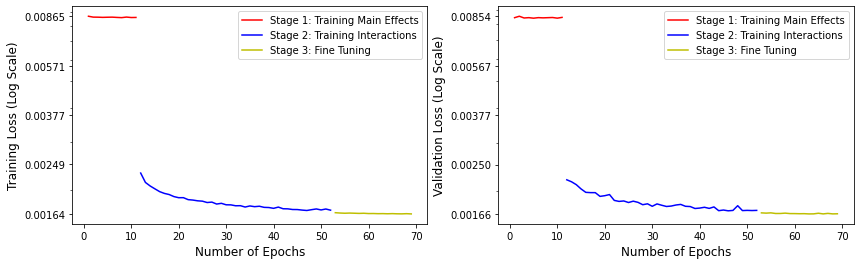

In [10]:
model.show_loss_trajectory()

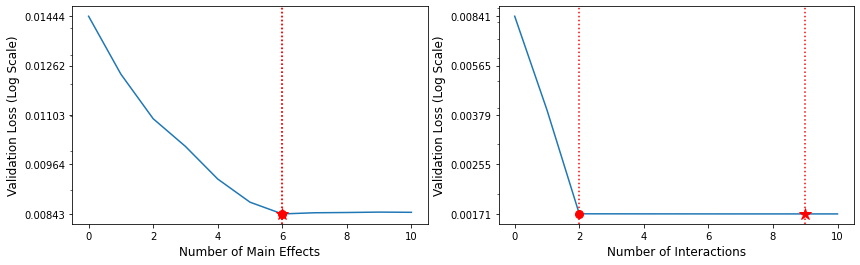

In [11]:
model.show_regularization_path()

### Global explaination

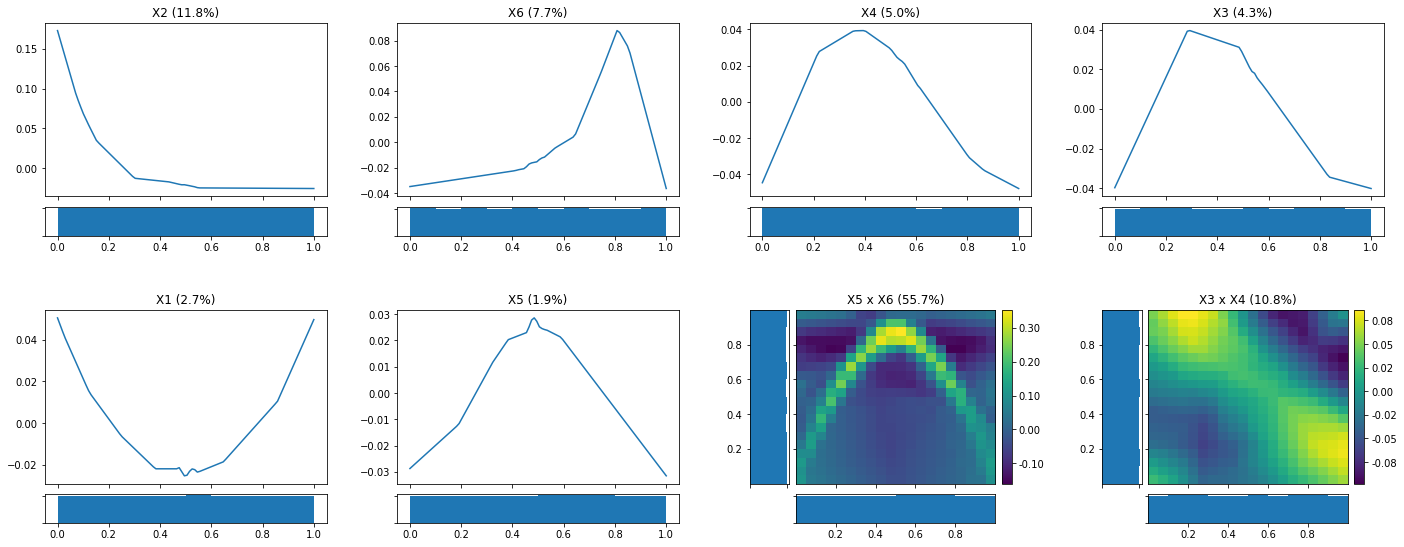

In [12]:
# show all effects 
model.show_global_explain()

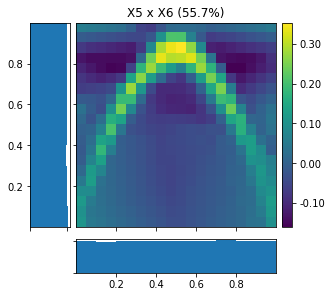

In [13]:
# show one specific effect
model.show_global_explain(key="X5 x X6")

### Feature and effect importance

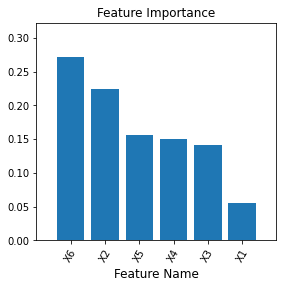

In [14]:
## feature importance 
model.show_feature_importance()

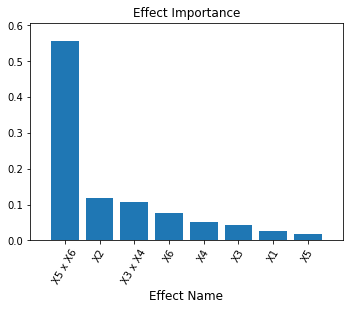

In [15]:
## effect importance 
model.show_effect_importance()

### Local Explain

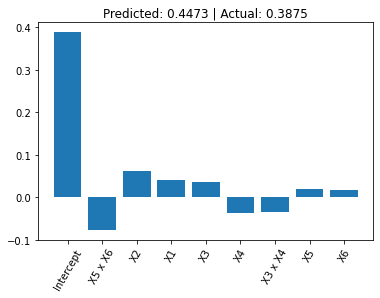

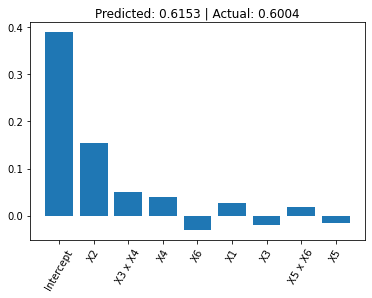

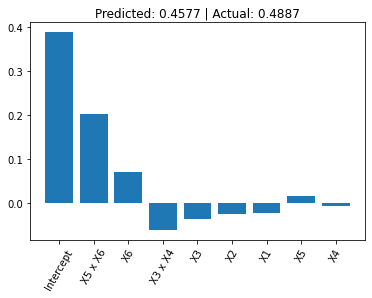

In [16]:
model.show_local_explain(train_x[:3], train_y[:3])

## Model save and load 

In [17]:
model.save(name="simu")
modelnew = GAMINetRegressor()
modelnew.load(name="simu")
modelnew.predict(train_x)

array([0.44731176, 0.61530155, 0.45772287, ..., 0.42139524, 0.3160211 ,
       0.53784806], dtype=float32)

In [18]:
# from matplotlib import pylab as plt
# item = model.warm_init_main_effect_data[92]
# plt.scatter(item["x"], item["gam"], alpha=0.5)
# plt.scatter(item["x"], item["gaminet"], alpha=0.5)

In [19]:
# from sklearn.utils.estimator_checks import check_estimator
# check = check_estimator(GAMINetRegressor())
# check = check_estimator(GAMINetClassifier())